##  **Import libraries**

In [1]:
import pandas as pd # data manipulation
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots
import warnings # Ignore warning messages

In [2]:
warnings.filterwarnings("ignore")

### **Load Data**

In [3]:
df=pd.read_csv("insurance.csv")

Using the histogram and the box plot. We confirm the presence of outliers. So we have to give it special processing.

Technically we can give outliers the same treatment as missing values.

* **Delete** those values.
* **Replace** them with a **statistical measure**.
* Use a **model**. So that it generates values closer to the real ones.

## **Feature engineering**

In [4]:
class lower_upper_limits():
    
    def __init__(self,dataset,feature,limit):
        
        self.dataset=dataset
        self.mean=dataset[feature].mean()
        self.std=dataset[feature].std()
        
        self.limit=limit
     

    def upper_limit(self):
    
        return self.mean+self.limit*self.std
    
    
    def lower_limit(self):
        
        return self.mean-self.limit*self.std
    

In [5]:
df.groupby("sex").describe()["bmi"]

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,662.0,30.377749,6.046023,16.815,26.125,30.1075,34.31375,48.07
male,676.0,30.943129,6.140435,15.960,26.410,30.6875,34.99250,53.13


#### *Selected from the best interval*

In [14]:
def selected_interval_upper(dataframe,feature,limits):
    

    for limit in limits:
        
        upper_limit=lower_upper_limits(dataframe,feature,limit).upper_limit()
        
        
        print(limit,upper_limit)
    
def selected_interval_lower(dataframe,feature,limits):
    
    
    for limit in limits:
        
        upper_limit=lower_upper_limits(df,"bmi",limit).lower_limit()
        
        print(limit,upper_limit)
 
    

### **Upper limit**

In [8]:
upper_intervals=np.arange(2,4,step=0.2)
upper_intervals=upper_intervals.round(2)

In [10]:
selected_interval_upper(df,"bmi",upper_intervals)

2.0 42.85977068434457
2.2 44.07940806668037
2.4 45.29904544901618
2.6 46.51868283135198
2.8 47.738320213687786
3.0 48.95795759602359
3.2 50.177594978359394
3.4 51.3972323606952
3.6 52.616869743031
3.8 53.8365071253668


With an interval of 3 it gives a good value. To be able to replace outliers.

### *Replaces values greater than the upper range*

In [11]:
df["bmi"]=np.where(df["bmi"]>48.95,48.95,df["bmi"])

### **Lower limit**


### *Replaces values ​​less than the lower range*

In [12]:
lower_intervals=np.arange(2,4,step=0.2)
lower_intervals=upper_intervals.round(2)

In [15]:
selected_interval_lower(df,"bmi",lower_intervals)

2.0 18.506082727141177
2.2 17.291050117941992
2.4 16.076017508742808
2.6 14.860984899543622
2.8 13.64595229034444
3.0 12.430919681145252
3.2 11.215887071946067
3.4 10.000854462746883
3.6 8.785821853547699
3.8 7.570789244348514


The appropriate interval value is 2. Since considered with the minimum BMI values ​​regardless of sex is 18.

In [16]:
df["bmi"]=np.where(df["bmi"]<18,18,df["bmi"])

In [17]:
sns.set_style(style="whitegrid")

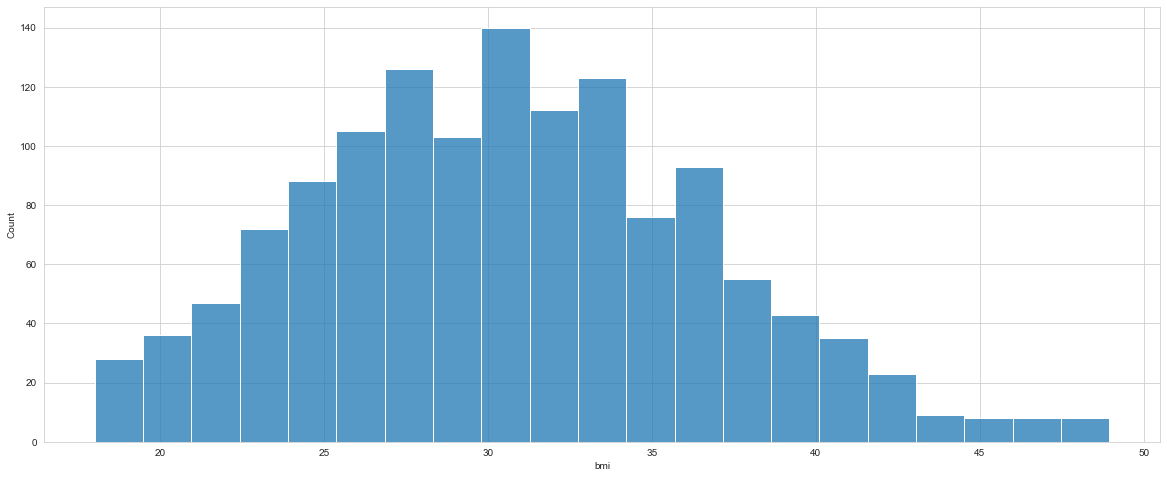

In [18]:
plt.subplots(1,1,figsize=(20,8))
sns.histplot(data=df,x="bmi")
plt.show()

In [19]:
smoker_no_split=df.query("smoker=='no'")
smoker_yes_split=df.query("smoker=='yes'")


We still see outliers. Therefore, I will decide to divide the dataset based on the age of the user. For better cleaning.

### **Smoker no split**

#### **Upper limit**

In [20]:
lower_upper_limits(smoker_no_split,"charges",2).upper_limit()

20421.831936246064

Using an interval of 2 gives good results. In addition, for this case, the values ​​that are out of the normal, we are going to transform them by null values ​​and later we are going to replace said value, using a linear model. Since there are variables that are highly correlated.

#### *Transform the outliers to null*

In [21]:
smoker_no_split["charges"]=smoker_no_split["charges"].apply(lambda x: np.nan if x > 20000 else x)

### *Calculate the percentage of null values*

In [22]:
((smoker_no_split.isnull().sum() / len(df))*100).sort_values(ascending = False)

charges     4.559043
age         0.000000
sex         0.000000
bmi         0.000000
children    0.000000
smoker      0.000000
region      0.000000
dtype: float64

In [25]:


def scatter_plot(dataframe,x,y):
    

    sns.lmplot(data=dataframe,x=x,y=y)
    plt.show()

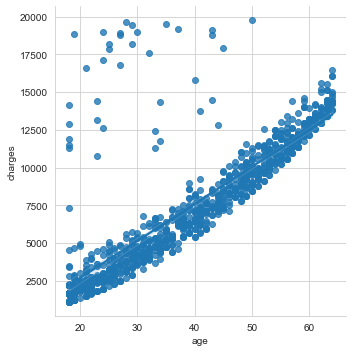

In [26]:
scatter_plot(smoker_no_split,"age","charges")

### Divide according to age.

In [27]:
young_adults_split=smoker_no_split.query("age<30")
adults_split=smoker_no_split.query("age>=30 and age<50")
old_adults_split=smoker_no_split.query("age>=50")

In [28]:
def outlires_to_nan(dataframe,upper_limit):
    
    return dataframe["charges"].apply(lambda x: np.nan if x>upper_limit else x)

In [29]:
young_adults_split["charges"]=outlires_to_nan(young_adults_split,7000)
adults_split["charges"]=outlires_to_nan(adults_split,10000)
old_adults_split["charges"]=outlires_to_nan(old_adults_split,18000)

In [30]:
smoker_no_split=pd.concat([young_adults_split,
                           adults_split,
                           old_adults_split])

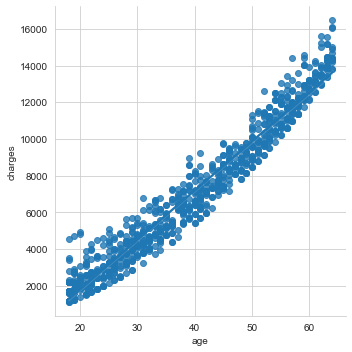

In [31]:
scatter_plot(smoker_no_split,"age","charges")

Now the data set is devoid of outliers. But to avoid data loss, we are going to create a model to be able to substitute null values. To have a better closeness than to replace them with a statistical measure.


### *Replace null values*

I will obtain by creating a linear regression model. To replace those values. Since the variables of age and insurance charge. It has a linear trend for non-smokers.

In [32]:
smoker_no_clear=smoker_no_split.dropna() # Eliminate nan values
smoker_no_nan=smoker_no_split[smoker_no_split["charges"].isnull()] # Select nan values

In [33]:
X=smoker_no_clear.drop(["charges","smoker"],axis="columns")
y=smoker_no_clear.charges

### *Split data in train and test*

In [34]:
from sklearn.model_selection import train_test_split,cross_val_score

In [35]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.33,random_state=0)

X_train.shape,X_test.shape

((636, 5), (314, 5))

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer #  Variables transform

In [37]:
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

In [38]:
tf_col=make_column_transformer((MinMaxScaler(),["age","bmi","children"]),
                              (OneHotEncoder(drop="if_binary"),["sex","region"]))

### *Linear Model*

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
lm=Pipeline([("preprocessor",tf_col),("linear_model",LinearRegression())])

lm.fit(X_train,Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sex', 'region'])])),
                ('linear_model', LinearRegression())])

In [41]:
lm.score(X_train,Y_train)

0.979297797969041

In [42]:
lm.score(X_test,Y_test)

0.9818515223070252

### *Cross validation*

In [43]:
cross_val_score(lm,X_test,Y_test,cv=5).mean()

0.9806776769021471

The generalization value was quite high. By which the linear model can describe 97% of the observations. We can use it to substitute missing values to avoid excessive data loss.

### *Substitution of null values*

In [44]:
new_data=smoker_no_nan.drop(["charges"],axis="columns")
smoker_no_nan["charges"]=lm.predict(new_data)

In [45]:
smoker_no_nan.head()

,age,sex,bmi,children,smoker,region,charges
102,18,female,30.115,0,no,northeast,1516.455194
143,29,male,29.735,2,no,northwest,4585.151560
219,24,female,23.210,0,no,southeast,2404.761100
291,29,male,29.640,1,no,northeast,4411.947852
305,29,male,33.345,2,no,northwest,4610.707459


In [46]:
smoker_no_nan.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [47]:
smoker_no_clear=pd.concat([smoker_no_clear,
                           smoker_no_nan])

### *Smoker yes splitt*

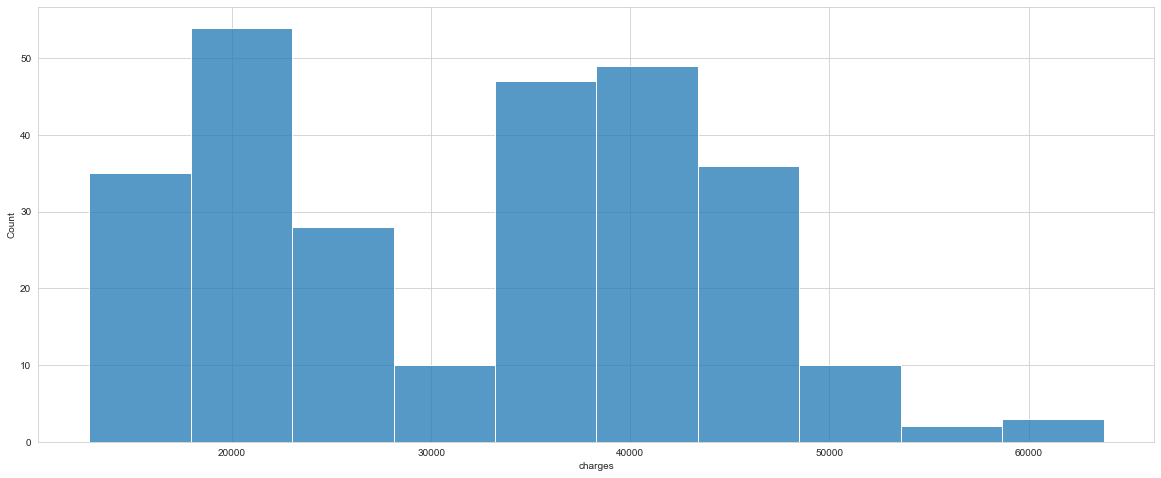

In [48]:
plt.figure(figsize=(20,8))
sns.histplot(data=smoker_yes_split,x="charges")
plt.show()

### *We replace the outliers*

In [52]:
smoker_yes_split["charges"]=smoker_yes_split["charges"].apply(lambda x: 48000 if x > 48000 else x)

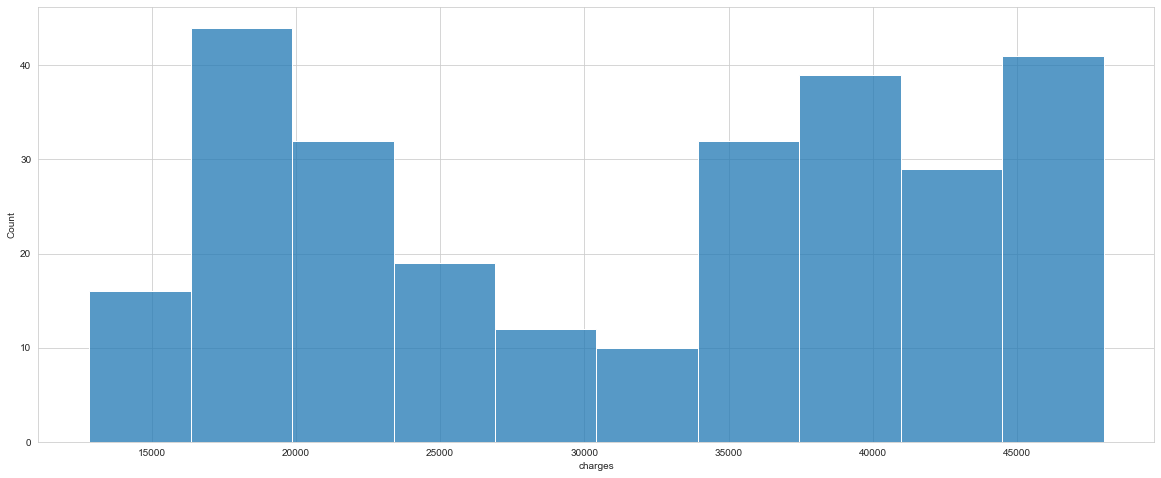

In [53]:
plt.figure(figsize=(20,8))
sns.histplot(data=smoker_yes_split,x="charges")
plt.show()

In [55]:
smoker_yes_clear=smoker_yes_split

In [56]:
df_clear=pd.concat([smoker_no_clear,smoker_yes_clear])

#### *We save the dataset with the clean data*

In [57]:
df_clear.to_csv("insurence_clear.csv")